<a href="https://colab.research.google.com/github/vivaldydermagia123/Project2/blob/main/Fraud_Detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import mutual_info_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import f_classif, SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score,balanced_accuracy_score,precision_score,recall_score,f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import joblib

In [ ]:
# # Mengatur agar tampilan tidak terpotong
pd.set_option('display.max_columns', None)  # Menampilkan semua kolom
# pd.set_option('display.max_rows', None)     # Menampilkan semua baris

# Load Dataset

**Kolom pada dataset**

---
1. trans_date_trans_time: Waktu transaksi. Dapat digunakan untuk mendeteksi pola waktu (misal transaksi yang sering terjadi pada waktu yang tidak wajar bisa dicurigai sebagai fraud).
2. cc_num: Nomor kartu kredit. Informasi penting terkait pengguna kartu, tetapi tidak langsung membantu mendeteksi fraud kecuali ada pola dari penggunaan kartu yang tidak biasa.
3. merchant: Nama merchant (penjual). Merchant tertentu mungkin lebih sering terlibat dalam transaksi fraud, sehingga bisa membantu mendeteksi risiko terkait merchant.
4. category: Kategori transaksi. Fraud mungkin lebih sering terjadi dalam kategori tertentu seperti barang mewah atau hiburan, yang memiliki nilai transaksi lebih tinggi.
5. amt: Jumlah uang dalam transaksi. Nilai transaksi yang sangat besar atau tidak sesuai dengan pola belanja biasanya bisa menjadi tanda fraud.
6. first: Nama depan pemegang kartu. Tidak terlalu relevan dalam mendeteksi fraud secara langsung.
7. last: Nama belakang pemegang kartu. Sama seperti first, tidak relevan secara langsung.
8. gender: Jenis kelamin pemegang kartu. Bisa digunakan untuk melihat pola demografis terkait fraud, meskipun tidak secara langsung mengindikasikan fraud.
9. street: Alamat jalan pemegang kartu. Dapat digunakan dalam deteksi anomali jika lokasi transaksi berbeda jauh dari alamat pemegang kartu.
10. city: Kota pemegang kartu. Sama seperti street, dapat digunakan untuk memeriksa ketidaksesuaian antara lokasi pemegang kartu dan transaksi.
11. state: Negara bagian pemegang kartu. Sama dengan city, bisa mendeteksi anomali lokasi.
12. zip: Kode pos pemegang kartu. Sama dengan city dan state, bisa membantu mendeteksi anomali geografis.
13. lat: Garis lintang lokasi pemegang kartu. Lokasi geografis dapat membantu mendeteksi ketidaksesuaian jika dibandingkan dengan lokasi transaksi.
14. long: Garis bujur lokasi pemegang kartu. Sama dengan lat, membantu mendeteksi lokasi.
15. city_pop: Populasi kota pemegang kartu. Bisa digunakan untuk memahami risiko terkait daerah, misalnya daerah padat penduduk mungkin memiliki lebih banyak transaksi dan risiko.
16. job: Pekerjaan pemegang kartu. Pekerjaan dengan penghasilan tinggi mungkin lebih rentan terhadap fraud karena lebih sering terlibat dalam transaksi besar.
17. dob: Tanggal lahir pemegang kartu. Usia pemegang kartu bisa menjadi faktor, misalnya kelompok usia tertentu mungkin lebih rentan terhadap fraud.
18. trans_num: ID unik untuk transaksi. Tidak relevan dalam deteksi fraud secara langsung.
19. unix_time: Waktu transaksi dalam format unix. Sama seperti trans_date_trans_time, membantu dalam menganalisis pola waktu.
20. merch_lat: Garis lintang merchant. Dapat digunakan untuk mendeteksi ketidaksesuaian antara lokasi merchant dan pemegang kartu.
21. merch_long: Garis bujur merchant. Sama seperti merch_lat, membantu mendeteksi anomali lokasi.
22. is_fraud: Label apakah transaksi adalah fraud (0 = tidak fraud, 1 = fraud). Ini adalah target yang perlu diprediksi.


In [ ]:
train = pd.read_csv('train.csv')
train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [ ]:
train['is_fraud'].value_counts(normalize=True)

is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64

Data Imbalance

In [ ]:
# mengubah datetime
train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'])
train['dob'] = pd.to_datetime(train['dob'])

# Membuat date dan time transaksi
train['trans_date'] = train['trans_date_trans_time'].dt.date
train['trans_time'] = train['trans_date_trans_time'].dt.time

# membuat tahun, bulan, hari tahun transaksi
train['year'] = train['trans_date_trans_time'].dt.year
train['month'] = train['trans_date_trans_time'].dt.month
train['day'] = train['trans_date_trans_time'].dt.day
train['day_of_week'] = train['trans_date_trans_time'].dt.weekday
train['hour'] = train['trans_date_trans_time'].dt.hour

In [ ]:
# Fungsi untuk menghitung jarak menggunakan rumus Haversine
def haversine(lat1, lon1, lat2, lon2):
    # Konversi dari derajat ke radian
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # Jarak dalam kilometer (radius bumi = 6371 km)
    distance = 6371 * c
    return distance

In [ ]:
# Menghitung jarak untuk setiap transaksi
train['distance'] = train.apply(lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)

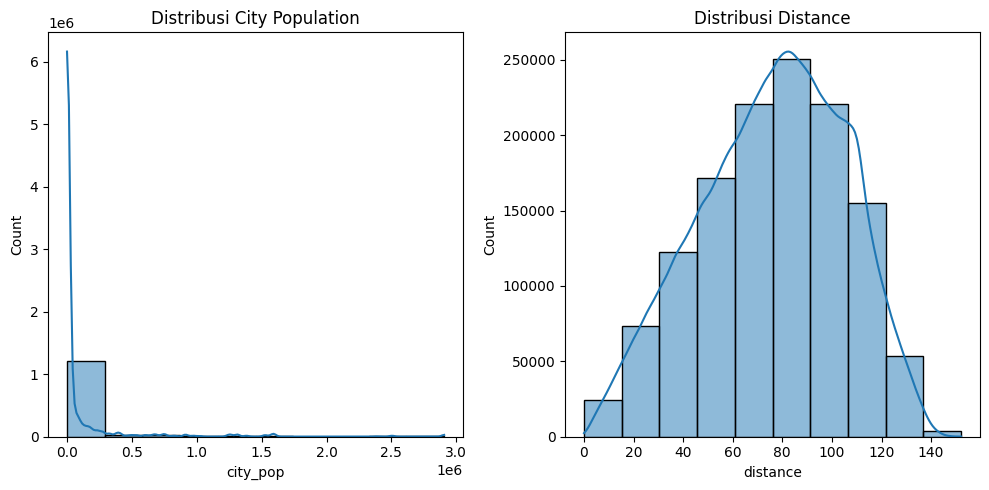

In [ ]:
# Melihat distribusi kolom city_pop dan distance
fig, axe = plt.subplots(1, 2, figsize=(10,5))
sns.histplot(train['city_pop'], bins=10, kde=True, ax=axe[0])
axe[0].set_title('Distribusi City Population')
sns.histplot(train['distance'], bins=10, kde=True, ax=axe[1])
axe[1].set_title('Distribusi Distance')
plt.tight_layout()
plt.show()


In [ ]:
# Membuat distance_category dan city_pop_category berdasarkan distribusi
# Membagi city_pop menjadi 3 kategori (low, medium, high)
train['city_pop_category_1'] = pd.qcut(train['city_pop'], q=3, labels=['low', 'medium', 'high']).astype(str)

# Membagi distance menjadi 3 kategori (dekat, sedang, jauh)
train['distance_category_1'] = pd.qcut(train['distance'], q=3, labels=['dekat', 'sedang', 'jauh']).astype(str)

In [ ]:
# Misalkan df adalah DataFrame yang berisi kolom 'distance'
bins = [0, train['distance'].median(), train['distance'].quantile(0.75), train['distance'].max()]
labels = ['dekat', 'sedang', 'jauh']

# Membuat kolom baru 'distance_category'
train['distance_category_2'] = pd.cut(train['distance'], bins=bins, labels=labels, include_lowest=True).astype(str)

In [ ]:
# Membuat kolom city_pop_category
bins = [0, train['city_pop'].median(), train['city_pop'].quantile(0.75), train['city_pop'].max()]
labels = ['low', 'medium', 'high']
train['city_pop_category_2'] = pd.cut(train['city_pop'], bins=bins, labels=labels, include_lowest=True).astype(str)

In [ ]:
train.groupby('distance_category_1')['distance'].agg(['count', 'mean', 'min', 'max'])

,count,mean,min,max
distance_category_1,,,,
dekat,432225,42.580036,0.022255,63.886874
jauh,432225,107.756905,91.332526,152.117173
sedang,432225,78.007010,63.886892,91.332504


In [ ]:
train.groupby('distance_category_2')['distance'].agg(['count', 'mean', 'min', 'max'])

,count,mean,min,max
distance_category_2,,,,
dekat,648338,52.152137,0.022255,78.231751
jauh,324169,112.055594,98.503290,152.117173
sedang,324168,88.098772,78.231953,98.503247


In [ ]:
train.groupby('city_pop_category_1')['city_pop'].agg(['count', 'mean', 'min', 'max'])

,count,mean,min,max
city_pop_category_1,,,,
high,431675,263228.703170,6951,2906700
low,432758,496.225371,23,1178
medium,432242,3082.614663,1179,6841


In [ ]:
train.groupby('city_pop_category_2')['city_pop'].agg(['count', 'mean', 'min', 'max'])

,count,mean,min,max
city_pop_category_2,,,,
high,323433,347110.203517,20478,2906700
low,649791,914.270807,23,2456
medium,323451,7158.586837,2457,20328


In [ ]:
# Membuat kolom risk_time
risk_time = list((22, 23, 0, 1, 2, 3))

train['risk_time'] = train['hour'].apply(lambda hour : 1 if hour in risk_time else 0)

In [ ]:
# Fungsi untuk menghitung age dari dob dan trans_date
def count_age(dob, trans_date):
  age = trans_date.year - dob.year - ((trans_date.month, trans_date.day) < (dob.month, dob.day))
  return age

In [ ]:
train['age'] = train.apply(lambda row: count_age(row['dob'], row['trans_date']), axis=1)

In [ ]:
# Filter data yang fraud
fraud = train.loc[train['is_fraud'] == 1]
print(f'Data Fraud : {len(fraud)}')

# filter fraud berdasar tahun
fraud_19 = fraud.loc[fraud['year'] == 2019]
fraud_20 = fraud.loc[fraud['year'] == 2020]

print(f'Data Fraud 2019 : {len(fraud_19)}')
print(f'Data Fraud 2020: {len(fraud_20)}')

Data Fraud : 7506
Data Fraud 2019 : 5220
Data Fraud 2020: 2286


In [ ]:
# group by category
fraud_category = fraud.groupby('category').size().reset_index(name='fraud_category_count')
fraud_category_sorted = fraud_category.sort_values(by='fraud_category_count', ascending=False)

# Gabungkan dataframe fraud_category dan train
train = train.merge(fraud_category, on='category', how='left')

# Membuat kolom category_risk
sort_fraud_category = train['fraud_category_count'].sort_values(ascending=False)
category_risk_threshold = sort_fraud_category.median()

train['category_risk'] = (train['fraud_category_count'] >= category_risk_threshold).astype(int)

In [ ]:
# Melihat variasi data
for col in train.columns:
  print(f'Kolom {col} : {train[col].nunique()}')

Kolom Unnamed: 0 : 1296675
Kolom trans_date_trans_time : 1274791
Kolom cc_num : 983
Kolom merchant : 693
Kolom category : 14
Kolom amt : 52928
Kolom first : 352
Kolom last : 481
Kolom gender : 2
Kolom street : 983
Kolom city : 894
Kolom state : 51
Kolom zip : 970
Kolom lat : 968
Kolom long : 969
Kolom city_pop : 879
Kolom job : 494
Kolom dob : 968
Kolom trans_num : 1296675
Kolom unix_time : 1274823
Kolom merch_lat : 1247805
Kolom merch_long : 1275745
Kolom is_fraud : 2
Kolom trans_date : 537
Kolom trans_time : 86400
Kolom year : 2
Kolom month : 12
Kolom day : 31
Kolom day_of_week : 7
Kolom hour : 24
Kolom distance : 1296675
Kolom city_pop_category_1 : 3
Kolom distance_category_1 : 3
Kolom distance_category_2 : 3
Kolom city_pop_category_2 : 3
Kolom risk_time : 2
Kolom age : 83
Kolom fraud_category_count : 14
Kolom category_risk : 2


In [ ]:
train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_date,trans_time,year,month,day,day_of_week,hour,distance,city_pop_category_1,distance_category_1,distance_category_2,city_pop_category_2,risk_time,age,fraud_category_count,category_risk
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019-01-01,00:00:18,2019,1,1,1,0,78.597568,medium,sedang,sedang,medium,1,30,915,1
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019-01-01,00:00:44,2019,1,1,1,0,30.212176,low,dekat,dekat,low,1,40,1743,1
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,2019-01-01,00:00:51,2019,1,1,1,0,108.206083,medium,jauh,jauh,medium,1,56,233,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,2019-01-01,00:01:16,2019,1,1,1,0,95.673231,medium,jauh,sedang,low,1,51,618,1
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,2019-01-01,00:03:06,2019,1,1,1,0,77.556744,low,sedang,dekat,low,1,32,250,1


In [ ]:
# cek data duplicated
train.duplicated().sum()

0

In [ ]:
# Cek Missing value
train.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
trans_date               0
trans_time               0
year                     0
month                    0
day                      0
day_of_week              0
hour                     0
distance                 0
city_pop_category_1      0
distance_category_1      0
distance_category_2      0
city_pop_category_2      0
risk_time                0
age                      0
f

Tidak ada missing value dan data duplikat

# EDA

## Analisis

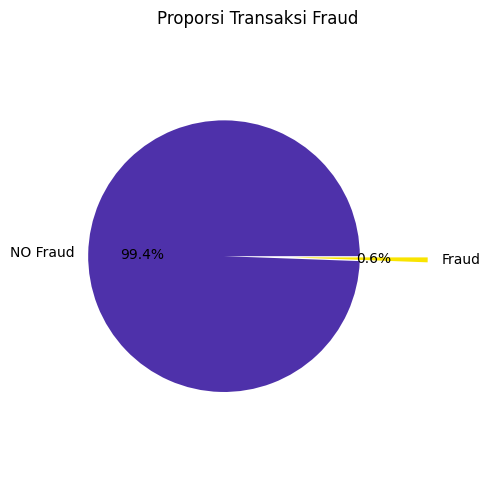

In [ ]:
fraud_counts = train['is_fraud'].value_counts().reset_index()

labels = ['NO Fraud', 'Fraud']
colors = ['#4E31AA', '#F9E400']
explode = (0.5, 0)

plt.figure(figsize=(5, 5))
plt.pie(x=fraud_counts['count'], explode=explode, labels=labels, autopct='%1.1f%%', colors=colors)
plt.title('Proporsi Transaksi Fraud')
plt.axis('equal')
plt.tight_layout()
plt.show()

C:\Users\I Gusti Ayu Melinia\AppData\Local\Temp\ipykernel_2188\2024805399.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=year_counts.index, y=year_counts.values, palette=colors)
C:\Users\I Gusti Ayu Melinia\AppData\Local\Temp\ipykernel_2188\2024805399.py:8: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(x=year_counts.index, y=year_counts.values, palette=colors)


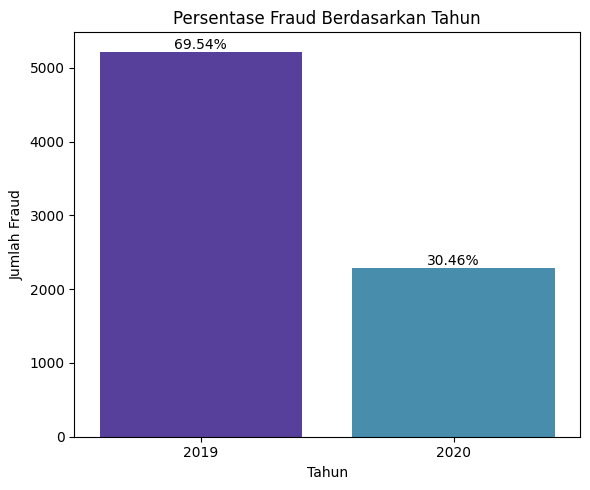

In [ ]:
# Hitung persentase setiap tahun
year_counts = fraud['year'].value_counts().sort_index()
year_percent = (year_counts / year_counts.sum()) * 100

# Plot bar chart dengan warna
colors = ['#4E31AA', '#3795BD', '#F9E400']
plt.figure(figsize=(6, 5))
sns.barplot(x=year_counts.index, y=year_counts.values, palette=colors)

# Tambahkan persentase di atas setiap bar
for i, count in enumerate(year_counts.values):
    percent = year_percent.iloc[i]
    plt.text(i, count, f'{percent:.2f}%', ha='center', va='bottom')

plt.title('Persentase Fraud Berdasarkan Tahun')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Fraud')
plt.tight_layout()
plt.show()

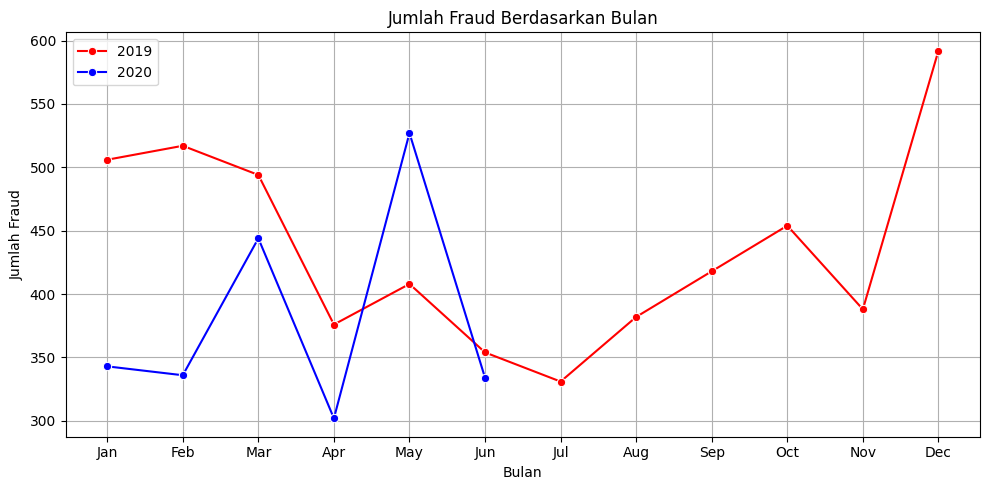

In [ ]:
# Hitung jumlah fraud per bulan untuk tahun 2019 dan 2020
month_counts_19 = fraud_19['month'].value_counts().sort_index()
month_counts_20 = fraud_20['month'].value_counts().sort_index()

# Plot line chart jumlah fraud berdasarkan bulan
plt.figure(figsize=(10,5))
sns.lineplot(x=month_counts_19.index, y=month_counts_19.values, marker='o', color='red', label='2019')
sns.lineplot(x=month_counts_20.index, y=month_counts_20.values, marker='o', color='blue', label='2020')

plt.title('Jumlah Fraud Berdasarkan Bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Fraud')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

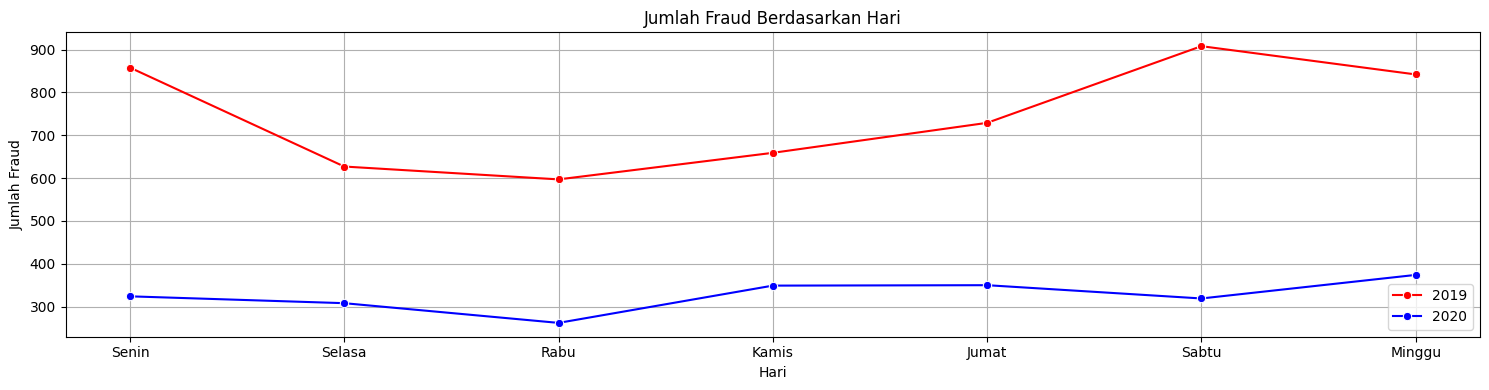

In [ ]:
# Hitung jumlah fraud per Hari untuk tahun 2019 dan 2020
day_counts_19 = fraud_19['day_of_week'].value_counts().sort_index()
day_counts_20 = fraud_20['day_of_week'].value_counts().sort_index()

# Plot line chart jumlah fraud berdasarkan bulan
plt.figure(figsize=(15,4))
sns.lineplot(x=day_counts_19.index, y=day_counts_19.values, marker='o', color='red', label='2019')
sns.lineplot(x=day_counts_20.index, y=day_counts_20.values, marker='o', color='blue', label='2020')

plt.title('Jumlah Fraud Berdasarkan Hari')
plt.xlabel('Hari')
plt.ylabel('Jumlah Fraud')
plt.xticks(ticks=range(0, 7), labels=['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat', 'Sabtu', 'Minggu'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

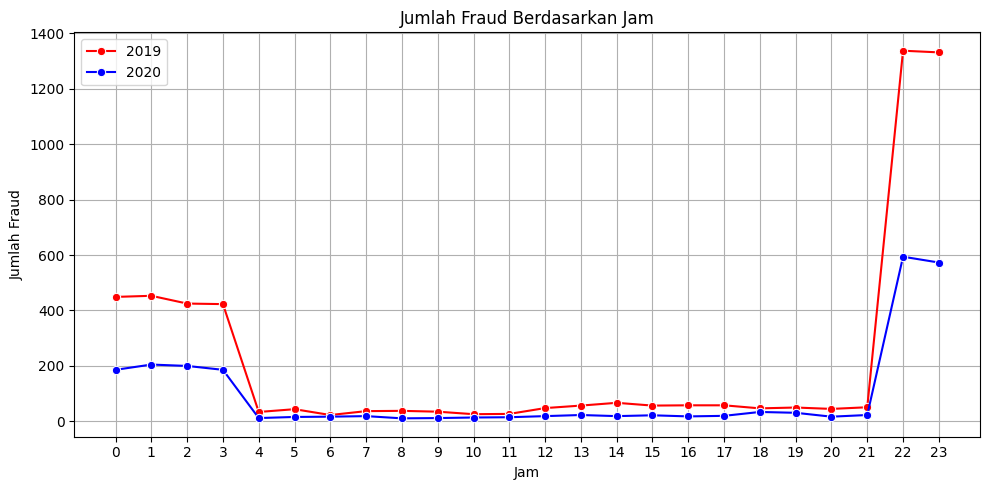

In [ ]:
# Hitung jam yang memiliki kasus fraud
hour_fraud_19 = fraud_19['hour'].value_counts().sort_index()
hour_fraud_20 = fraud_20['hour'].value_counts().sort_index()

# Chart plot
plt.figure(figsize=(10,5))
sns.lineplot(x=hour_fraud_19.index, y=hour_fraud_19.values, marker='o', color='red', label='2019')
sns.lineplot(x=hour_fraud_20.index, y=hour_fraud_20.values, marker='o', color='blue', label='2020')
plt.title('Jumlah Fraud Berdasarkan Jam')
plt.xlabel('Jam')
plt.ylabel('Jumlah Fraud')
plt.xticks(ticks=range(0,24))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\I Gusti Ayu Melinia\AppData\Local\Temp\ipykernel_2188\2843542823.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percent = gender_percent[i]


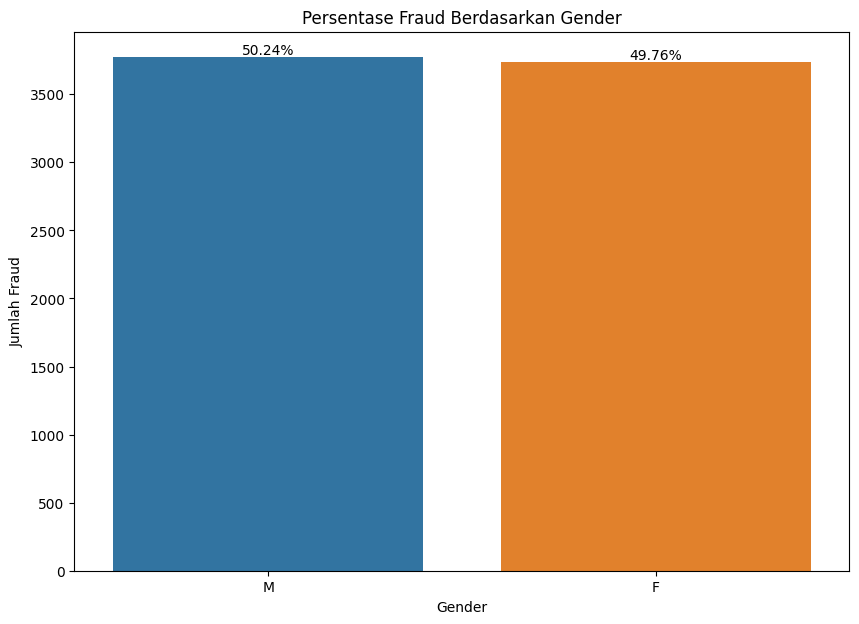

In [ ]:
# Hitung persentase setiap gender
gender_counts = fraud['gender'].value_counts()
gender_percent = (gender_counts / gender_counts.sum()) * 100

# Plot bar chart
plt.figure(figsize=(10,7))
sns.countplot(x='gender', hue='gender', data=fraud)

# Tambahkan persentase di atas setiap bar
for i, count in enumerate(gender_counts):
    percent = gender_percent[i]
    plt.text(i, count, f'{percent:.2f}%', ha='center', va='bottom')

plt.title('Persentase Fraud Berdasarkan Gender')
plt.xlabel('Gender')
plt.ylabel('Jumlah Fraud')
plt.show()

C:\Users\I Gusti Ayu Melinia\AppData\Local\Temp\ipykernel_2188\3467492565.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percent = category_percent[i]


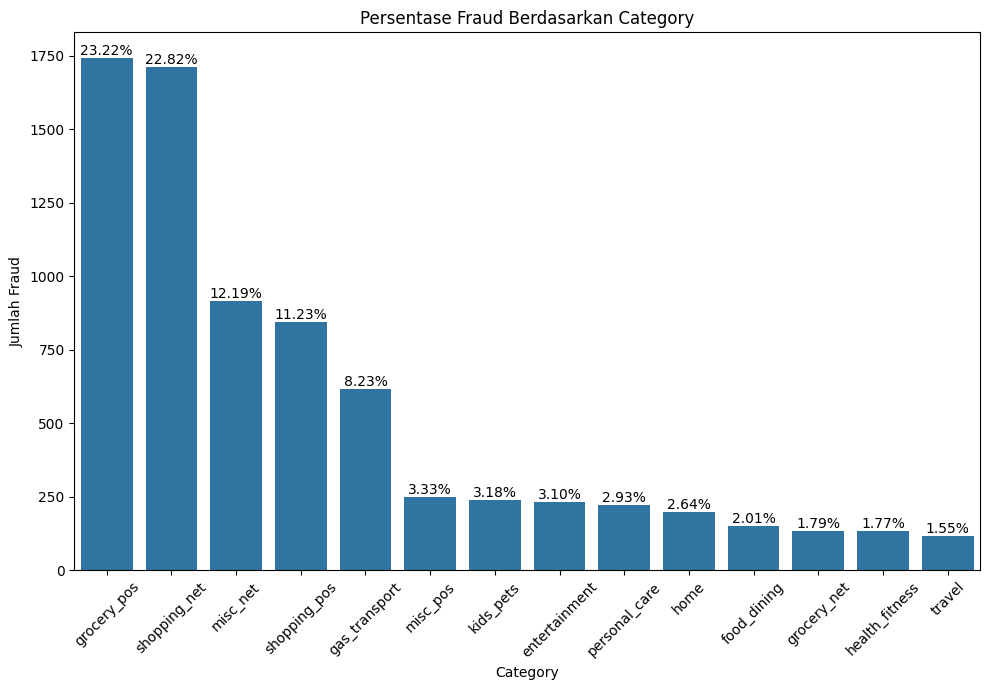

In [ ]:
# Hitung persentase setiap category
category_counts = fraud['category'].value_counts()
category_percent = (category_counts / category_counts.sum()) * 100

# Plot bar chart
plt.figure(figsize=(10,7))
sns.countplot(x='category', data=fraud, order=category_counts.index)

# Tambahkan persentase di atas setiap bar
for i, count in enumerate(category_counts):
    percent = category_percent[i]
    plt.text(i, count, f'{percent:.2f}%', ha='center', va='bottom')

plt.title('Persentase Fraud Berdasarkan Category')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.ylabel('Jumlah Fraud')
plt.tight_layout()
plt.show()

In [ ]:
# Kelompokkan data berdasarkan 'state', 'city', dan 'city_pop', lalu hitung jumlah fraud
fraud_by_location = fraud.groupby(['state', 'city', 'city_pop']).size().reset_index(name='fraud_count')

# Urutkan berdasarkan jumlah fraud terbanyak
fraud_by_location_sorted = fraud_by_location.sort_values(by='fraud_count', ascending=False)

# Tampilkan hasil 7 terbanyak
fraud_by_location_sorted.head(7)

,state,city,city_pop,fraud_count
615,TX,Houston,2906700,39
104,FL,Naples,276002,29
12,AL,Huntsville,190178,29
196,KS,Topeka,163415,27
606,TX,Dallas,1263321,27
499,OK,Tulsa,413574,27
259,MI,Detroit,673342,26


In [ ]:
fraud.groupby('distance_category_1')['distance'].agg(['count', 'mean', 'min', 'max'])

,count,mean,min,max
distance_category_1,,,,
dekat,2481,43.104718,0.738769,63.820568
jauh,2492,107.670673,91.333362,144.522410
sedang,2533,77.857070,63.903141,91.329156


In [ ]:
fraud.groupby('city_pop_category_1')['city_pop'].agg(['count', 'mean', 'min', 'max'])

,count,mean,min,max
city_pop_category_1,,,,
high,2632,274181.251900,6951,2906700
low,2473,476.899313,23,1178
medium,2401,3054.959600,1179,6629


C:\Users\I Gusti Ayu Melinia\AppData\Local\Temp\ipykernel_2188\1739775718.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='distance_category_1', data=fraud, palette=colors)


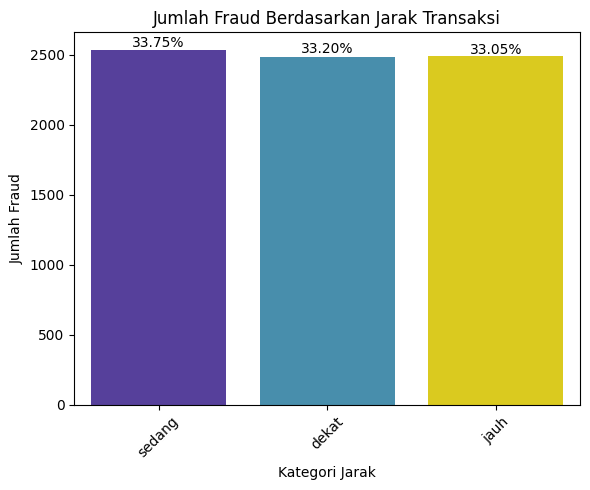

In [ ]:
distance_counts = fraud['distance_category_1'].value_counts()
distance_percent = (distance_counts / distance_counts.sum()) * 100

# melihat selisih jarak tansaksi yang banyak fraud
plt.figure(figsize=(6, 5))
colors = ['#4E31AA', '#3795BD', '#F9E400']
sns.countplot(x='distance_category_1', data=fraud, palette=colors)

# Tambahkan persentase di atas setiap bar
for i, count in enumerate(distance_counts):
  percent = distance_percent.iloc[i]
  plt.text(i, count, f'{percent:.2f}%', ha='center', va='bottom')

plt.title('Jumlah Fraud Berdasarkan Jarak Transaksi')
plt.xlabel('Kategori Jarak')
plt.ylabel('Jumlah Fraud')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\I Gusti Ayu Melinia\AppData\Local\Temp\ipykernel_2188\3950811418.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='distance_category_2', data=fraud, palette=colors)


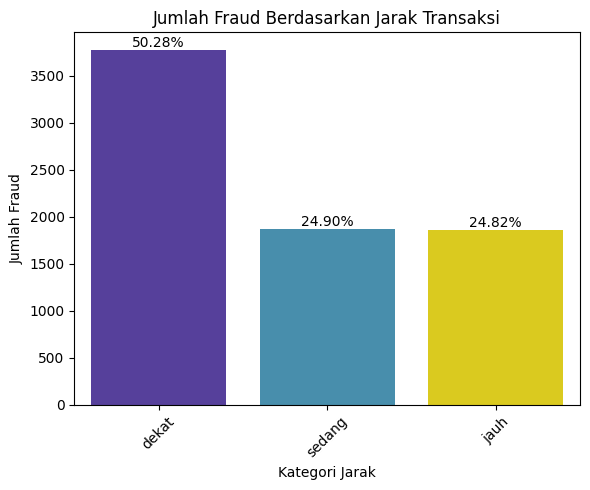

In [ ]:
distance_counts = fraud['distance_category_2'].value_counts()
distance_percent = (distance_counts / distance_counts.sum()) * 100

# melihat selisih jarak tansaksi yang banyak fraud
plt.figure(figsize=(6, 5))
colors = ['#4E31AA', '#3795BD', '#F9E400']
sns.countplot(x='distance_category_2', data=fraud, palette=colors)

# Tambahkan persentase di atas setiap bar
for i, count in enumerate(distance_counts):
  percent = distance_percent.iloc[i]
  plt.text(i, count, f'{percent:.2f}%', ha='center', va='bottom')

plt.title('Jumlah Fraud Berdasarkan Jarak Transaksi')
plt.xlabel('Kategori Jarak')
plt.ylabel('Jumlah Fraud')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# distance_counts = fraud['distance_category'].value_counts()
# distance_percent = (distance_counts / distance_counts.sum()) * 100

# # melihat selisih jarak tansaksi yang banyak fraud
# plt.figure(figsize=(6, 5))
# colors = ['#4E31AA', '#3795BD', '#F9E400']
# sns.countplot(x='distance_category', data=fraud, palette=colors)

# # Tambahkan persentase di atas setiap bar
# for i, count in enumerate(distance_counts):
#   percent = distance_percent.iloc[i]
#   plt.text(i, count, f'{percent:.2f}%', ha='center', va='bottom')

# plt.title('Jumlah Fraud Berdasarkan Jarak Transaksi')
# plt.xlabel('Kategori Jarak')
# plt.ylabel('Jumlah Fraud')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

C:\Users\I Gusti Ayu Melinia\AppData\Local\Temp\ipykernel_2188\1259316865.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='city_pop_category_1', data=fraud, palette=colors)


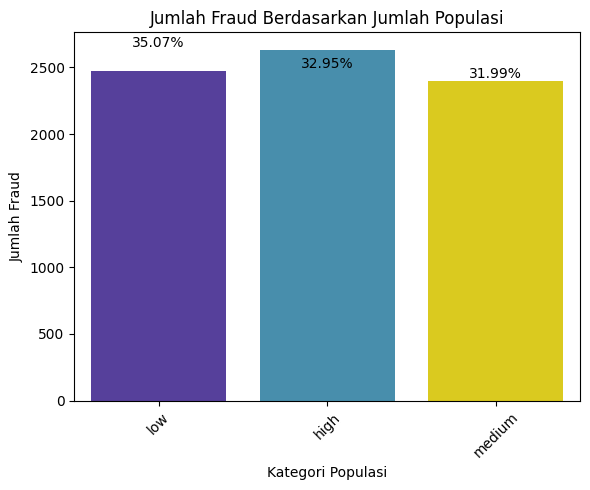

In [ ]:
city_pop_counts = fraud['city_pop_category_1'].value_counts()
city_pop_percent = (city_pop_counts / city_pop_counts.sum()) * 100

# melihat selisih jarak tansaksi yang banyak fraud
plt.figure(figsize=(6, 5))
colors = ['#4E31AA', '#3795BD', '#F9E400']
sns.countplot(x='city_pop_category_1', data=fraud, palette=colors)

# Tambahkan persentase di atas setiap bar
for i, count in enumerate(city_pop_counts):
  percent = city_pop_percent.iloc[i]
  plt.text(i, count, f'{percent:.2f}%', ha='center', va='bottom')

plt.title('Jumlah Fraud Berdasarkan Jumlah Populasi')
plt.xlabel('Kategori Populasi')
plt.ylabel('Jumlah Fraud')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\I Gusti Ayu Melinia\AppData\Local\Temp\ipykernel_2188\883855601.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='city_pop_category_2', data=fraud, palette=colors)


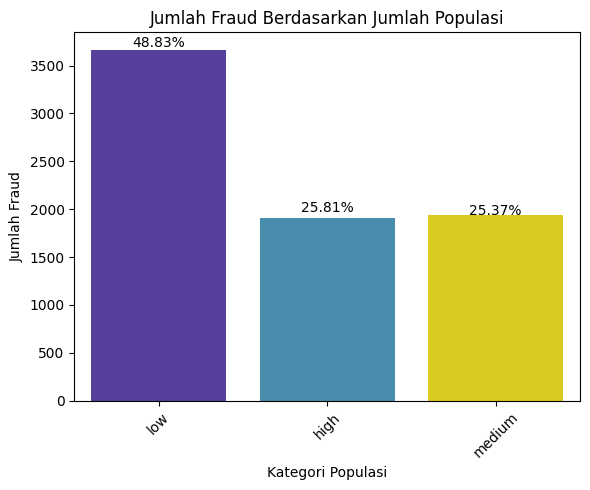

In [ ]:
city_pop_counts = fraud['city_pop_category_2'].value_counts()
city_pop_percent = (city_pop_counts / city_pop_counts.sum()) * 100

# melihat selisih jarak tansaksi yang banyak fraud
plt.figure(figsize=(6, 5))
colors = ['#4E31AA', '#3795BD', '#F9E400']
sns.countplot(x='city_pop_category_2', data=fraud, palette=colors)

# Tambahkan persentase di atas setiap bar
for i, count in enumerate(city_pop_counts):
  percent = city_pop_percent.iloc[i]
  plt.text(i, count, f'{percent:.2f}%', ha='center', va='bottom')

plt.title('Jumlah Fraud Berdasarkan Jumlah Populasi')
plt.xlabel('Kategori Populasi')
plt.ylabel('Jumlah Fraud')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# city_pop_counts = fraud['city_pop_category'].value_counts()
# city_pop_percent = (city_pop_counts / city_pop_counts.sum()) * 100

# # melihat selisih jarak tansaksi yang banyak fraud
# plt.figure(figsize=(6, 5))
# colors = ['#4E31AA', '#3795BD', '#F9E400']
# sns.countplot(x='city_pop_category', data=fraud, palette=colors)

# # Tambahkan persentase di atas setiap bar
# for i, count in enumerate(city_pop_counts):
#   percent = city_pop_percent.iloc[i]
#   plt.text(i, count, f'{percent:.2f}%', ha='center', va='bottom')

# plt.title('Jumlah Fraud Berdasarkan Jumlah Populasi')
# plt.xlabel('Kategori Populasi')
# plt.ylabel('Jumlah Fraud')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [ ]:
# Drop kolom identity
df_train = train.copy()
df_train.drop(columns=['trans_date','trans_time',  'merchant', 'dob','Unnamed: 0', 'cc_num', 'trans_num', 'first', 'last', 'street', 'zip', 'unix_time', 'merch_lat', 'merch_long', 'lat', 'long', 'trans_date_trans_time' ],
              inplace=True)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   category              1296675 non-null  object 
 1   amt                   1296675 non-null  float64
 2   gender                1296675 non-null  object 
 3   city                  1296675 non-null  object 
 4   state                 1296675 non-null  object 
 5   city_pop              1296675 non-null  int64  
 6   job                   1296675 non-null  object 
 7   is_fraud              1296675 non-null  int64  
 8   year                  1296675 non-null  int32  
 9   month                 1296675 non-null  int32  
 10  day                   1296675 non-null  int32  
 11  day_of_week           1296675 non-null  int32  
 12  hour                  1296675 non-null  int32  
 13  distance              1296675 non-null  float64
 14  city_pop_category_1   1296675 non-

In [ ]:
#Memisahkan kolom
time_cols = list(df_train.columns[8:13])
cat_cols = [var for var in df_train.columns if df_train[var].dtypes == 'O' and var not in time_cols]
dis_cols = [var for var in df_train.columns if df_train[var].nunique() < 10 and var not in cat_cols + time_cols]
con_cols = [var for var in df_train.columns if var not in cat_cols + time_cols + dis_cols + ['is_fraud']]

print(f"Categorical Variable \n{cat_cols}\n \ndiscreate variable \n{dis_cols}\n \ncontinuous variable \n{con_cols}\n \ntime variable \n{time_cols}")

Categorical Variable 
['category', 'gender', 'city', 'state', 'job', 'city_pop_category_1', 'distance_category_1', 'distance_category_2', 'city_pop_category_2']
 
discreate variable 
['is_fraud', 'risk_time', 'category_risk']
 
continuous variable 
['amt', 'city_pop', 'distance', 'age', 'fraud_category_count']
 
time variable 
['year', 'month', 'day', 'day_of_week', 'hour']


**Note** :
- Hanya terdapat 0.6% transaksi yang fraud pada dataset dari tahun 2019-2020
- transaksi 2019 terjadi hingga bulan desember sedangkan 2020 hanya terjadi sampai bulan juni, sehingga transaksi fraud banyak terjadi pada tahun 2019   
- transaksi terjadi hanya pada tahun 2019 dan 2020 dengan kasus fraud terbanyak pada tahun 2019 pada bulan desember dan 2020 bulan mei
- transaksi dengan kasus fraud pada tahun 2019 dan 2020 tidak terjadi secara signifikan berdasarkan hari
- transaksi fraud sering terjadi pada saat jam-jam orang tidur di malam hari jam 10 malam sampai 3 pagi.
- transaksi fraud tidak terjadi secara signifikan berdasarkan gender, namun Pria (Male) memiliki kecenderungan lebih tinggi dalam melakukan fraud dibandingkan wanita.
- kategori transaksi yang sering terjadi fraud adalah grocery_pos, shopping_net, misc_net, shopping_pos
- kasus transaksi fraud paling banyak terjadi di Texas koto Houston dengan populasi 2.906.700 jiwa yaitu sebanyak 39 kasus
- Beberapa kota yang teridentifikasi memiliki kecenderungan lebih tinggi untuk terlibat dalam fraud meliputi:
Angwin, Ashland, Beacon, Brookfield, Bruce, Buellton, Byesville, Chattanooga, Clarion, Claypool, Clinton, Coulee Dam, Crouse, Downey, East China, Freeport, Gaines, Granbury, Greenport, Grenola, Hubbell, Irvington, Isanti, Kaktovik, Karns City, La Grande, Las Vegas, Lockhart, Madisonville, Marshall, Medford, Melville, Mineral, Morven, Moss Point, Mount Vernon, Mountain City, Nanuet, Nicholson, Noblesville, Norfolk, North East, Oakton, Orange Park, Phelps, Pleasant Hill, Queen Anne, Ridge Spring, Roland, Seattle, Streator, Vacaville, Walkertown, Wappapello, Wartburg, Waukau, West Frankfort, Winnsboro.
- Delaware (DE) menunjukkan kecenderungan fraud yang lebih tinggi dibandingkan negara bagian lainnya.
- Kota dengan populasi tinggi dan populasi rendah cenderung memiliki tingkat fraud yang lebih tinggi dibandingkan kota dengan populasi menengah.
- Pelanggan dengan jarak sedang dan jarak jauh dari merchant cenderung lebih banyak melakukan fraud dibandingkan mereka yang tinggal lebih dekat.


In [ ]:
global_mean = df_train['is_fraud'].mean()

# looping for each catl cols
for categorical in cat_cols[1:]:
    df_group = df_train.groupby(by=categorical)['is_fraud'].agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group.style.background_gradient(low=0.7, high=1.0,cmap='YlOrRd'))

,mean,diff,risk
gender,,,
F,0.005262,-0.000527,0.908947
M,0.006426,0.000638,1.110146


,mean,diff,risk
city,,,
Achille,0.024436,0.018647,4.221379
Acworth,0.006199,0.000411,1.070946
Adams,0.000000,-0.005789,0.000000
Afton,0.004423,-0.001366,0.764013
Akron,0.000000,-0.005789,0.000000
Albany,0.018939,0.013151,3.271814
Albuquerque,0.023415,0.017626,4.044920
Alder,0.008832,0.003044,1.525776
Aledo,0.010638,0.004850,1.837785


,mean,diff,risk
state,,,
AK,0.016981,0.011192,2.933521
AL,0.005245,-0.000543,0.906137
AR,0.005172,-0.000616,0.893534
AZ,0.003435,-0.002353,0.593483
CA,0.005784,-0.000004,0.999239
CO,0.008141,0.002353,1.406409
CT,0.002077,-0.003711,0.358872
DC,0.005812,0.000024,1.004093
DE,1.000000,0.994211,172.751799


,mean,diff,risk
job,,,
Academic librarian,0.010567,0.004778,1.825427
"Accountant, chartered",1.000000,0.994211,172.751799
"Accountant, chartered certified",0.016854,0.011065,2.911547
"Accountant, chartered public finance",0.003488,-0.002300,0.602623
Accounting technician,0.007062,0.001273,1.219946
Acupuncturist,0.006341,0.000553,1.095446
Administrator,0.003330,-0.002459,0.575200
"Administrator, arts",0.013084,0.007295,2.260304
"Administrator, charities/voluntary organisations",0.001981,-0.003808,0.342218


,mean,diff,risk
city_pop_category_1,,,
high,0.006097,0.000309,1.053299
low,0.005715,-0.000074,0.987192
medium,0.005555,-0.000234,0.959595


,mean,diff,risk
distance_category_1,,,
dekat,0.005740,-0.000049,0.991607
jauh,0.005766,-0.000023,0.996003
sedang,0.005860,0.000072,1.012390


,mean,diff,risk
distance_category_2,,,
dekat,0.005821,0.000032,1.005595
jauh,0.005747,-0.000042,0.992805
sedang,0.005766,-0.000023,0.996006


,mean,diff,risk
city_pop_category_2,,,
high,0.005887,0.000098,1.016963
low,0.005640,-0.000148,0.974368
medium,0.005989,0.000200,1.034531


## Feature Selection

In [ ]:
# Mutual information
def mutual_information_score(series):
    return mutual_info_score(series,df_train['is_fraud'])

df_mi = df_train[cat_cols].apply(mutual_information_score)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')

df_mi.style.background_gradient(low=0.7, high=1.0,cmap='YlOrRd')

,MI
city,0.004663
job,0.002173
category,0.002154
state,0.000151
gender,0.000029
city_pop_category_1,0.000004
city_pop_category_2,0.000002
distance_category_1,0.000000
distance_category_2,0.000000


**Kesimpulan MI:**

 Secara keseluruhan, meskipun semua fitur memiliki nilai MI yang rendah, city adalah fitur kategorikal yang paling relevan terhadap fraud, namun kontribusinya masih cukup kecil. Ini bisa berarti bahwa variabel kategorikal ini tidak terlalu kuat dalam menentukan apakah suatu transaksi adalah fraud.

In [ ]:
# VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = con_cols
vif_data["VIF"] = [variance_inflation_factor(df_train[con_cols].values, i) for i in range(len(con_cols))]
vif_data

,Feature,VIF
0,amt,1.195988
1,city_pop,1.078429
2,distance,4.506820
3,age,4.449302
4,fraud_category_count,1.980725


**Kesimpulan VIF**:

 Tidak ada multikolinearitas yang signifikan antara variabel continuous, meskipun distance dan age memiliki nilai VIF yang relatif lebih tinggi dibandingkan variabel lainnya. Namun, ini tidak dianggap sebagai masalah besar dalam model.

***Threshold VIF > 5 = ada multikolinearitas***

In [ ]:
# Uji test ANOVA
# Memisahkan fitur dengan Target untuk kebutuhan analisis
X = df_train[con_cols]
y = df_train['is_fraud']

# Melihat hubungan yang signifikan antara fitur dengan target dengan ANOVA
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)
scores = selector.scores_
p_values = selector.pvalues_

# Menampilkan skor dan p-value setiap fitur
for i, (score, p_value) in enumerate(zip(scores, p_values)):
    print(f"Fitur {con_cols[i]}: Skor F = {score}, p-value = {p_value}")

Fitur amt: Skor F = 65576.03460408215, p-value = 0.0
Fitur city_pop: Skor F = 5.9155518320156775, p-value = 0.015007935755578803
Fitur distance: Skor F = 0.21031364935511054, p-value = 0.6465217565861164
Fitur age: Skor F = 194.54856908018786, p-value = 3.2564025166462755e-44
Fitur fraud_category_count: Skor F = 5912.727371962211, p-value = 0.0


**Note :**

Berdasarkan uji ANOVA antara feature continues dengan target. feature yang dianggap signifikan dan penting oleh model adalah amt, fraud_category_count, age.

In [ ]:
# Uji test Chi square
# Melakukan One-Hot Encoding pada cat_cols
X = df_train[['category', 'gender', 'city_pop_category_1', 'distance_category_1', 'risk_time', 'category_risk']]
X_encoded = pd.get_dummies(X)

# Memisahkan target
y = df_train['is_fraud']

# Melakukan uji Chi-Square
chi_square = chi2(X_encoded, y)
p_values = chi_square[1]
chi_scores = chi_square[0]

# Menampilkan score
df_chi = pd.DataFrame({'feature': X_encoded.columns,
                       'chi_score': chi_scores,
                       'p_value': p_values})

# Mengurutkan berdasarkan chi_score
df_chi.sort_values(by='chi_score', ascending=False, inplace=True)
df_chi

,feature,chi_score,p_value
0,risk_time,12044.488049,0.000000e+00
13,category_shopping_net,2349.102721,0.000000e+00
6,category_grocery_pos,1483.162475,0.000000e+00
1,category_risk,1077.846368,2.157221e-236
10,category_misc_net,826.467565,9.498430e-182
8,category_home,373.843955,2.724315e-83
3,category_food_dining,272.077433,4.000812e-61
7,category_health_fitness,268.259181,2.718427e-60
9,category_kids_pets,265.153361,1.291957e-59
2,category_entertainment,179.007173,7.983587e-41


In [ ]:
# Menampilkan chi2 yang p_value < 0.005
df_chi.loc[df_chi['p_value'] <= 0.005]

,feature,chi_score,p_value
0,risk_time,12044.488049,0.000000e+00
13,category_shopping_net,2349.102721,0.000000e+00
6,category_grocery_pos,1483.162475,0.000000e+00
1,category_risk,1077.846368,2.157221e-236
10,category_misc_net,826.467565,9.498430e-182
8,category_home,373.843955,2.724315e-83
3,category_food_dining,272.077433,4.000812e-61
7,category_health_fitness,268.259181,2.718427e-60
9,category_kids_pets,265.153361,1.291957e-59
2,category_entertainment,179.007173,7.983587e-41


Question : feature apa aja yang bisa kita pakai untuk melatih model?
- kolom kategorik yg kita miliki memiliki banyak kategori di dalamnya, bisa di ohe jadi ngebuat banyak kolom baru dan mungkun tidak efektif untuk model? atau setelah di ohe kita pca terlebih dahulu kemudian di masukan ke dalam pelatihan?
- buat kolom kategorik yang merepresentasikan kemunculannya di dalam dataset? (frequancy encode)
- buat kolom kategorik yang merepresentasikan nilai mean dari setiap kategorik yang merupakan kasus fraud? (target encode)


In [ ]:
print(f'Kolom Kategorik : {cat_cols}')
print(f'Kolom Continues : {con_cols}')
print(f'Kolom Diskrit : {dis_cols}')
print(f'Kolom Time : {time_cols}')

Kolom Kategorik : ['category', 'gender', 'city', 'state', 'job', 'city_pop_category_1', 'distance_category_1', 'distance_category_2', 'city_pop_category_2']
Kolom Continues : ['amt', 'city_pop', 'distance', 'age', 'fraud_category_count']
Kolom Diskrit : ['is_fraud', 'risk_time', 'category_risk']
Kolom Time : ['year', 'month', 'day', 'day_of_week', 'hour']


Kolom yang dipilih : ['category', 'gender', 'city_pop_category_1', 'distance_category_1', 'risk_time', 'category_risk', 'amt', 'fraud_category_count', 'age'] + time_cols

# Modeling

In [ ]:
# Define coloms to encode
ohe_colom =list(df_train[['category', 'gender']])
ordinal_colom = list(df_train[['city_pop_category_1', 'distance_category_1']])
diskrit_colum = list(df_train[['risk_time', 'category_risk']])
con_colom = list(df_train[['amt', 'age', 'fraud_category_count']])

In [ ]:
print(f'Kolom yang digunakan dalam melatih model :\n')
print(f'Kolom Kategorik : {ohe_colom, ordinal_colom}')
print(f'Kolom Diskrit : {diskrit_colum}')
print(f'Kolom Continues : {con_colom}')

Kolom yang digunakan dalam melatih model :

Kolom Kategorik : (['category', 'gender'], ['city_pop_category_1', 'distance_category_1'])
Kolom Diskrit : ['risk_time', 'category_risk']
Kolom Continues : ['amt', 'age', 'fraud_category_count']


In [ ]:
# split data feature dan target
X = pd.concat([df_train[ohe_colom], df_train[ordinal_colom],df_train[diskrit_colum], df_train[con_colom], df_train[time_cols]], axis=1)
y = df_train['is_fraud']

# Buat train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=79, stratify=y)

In [ ]:
X.head()

,category,gender,city_pop_category_1,distance_category_1,risk_time,category_risk,amt,age,fraud_category_count,year,month,day,day_of_week,hour
0,misc_net,F,medium,sedang,1,1,4.97,30,915,2019,1,1,1,0
1,grocery_pos,F,low,dekat,1,1,107.23,40,1743,2019,1,1,1,0
2,entertainment,M,medium,jauh,1,0,220.11,56,233,2019,1,1,1,0
3,gas_transport,M,medium,jauh,1,1,45.00,51,618,2019,1,1,1,0
4,misc_pos,M,low,sedang,1,1,41.96,32,250,2019,1,1,1,0


In [ ]:
class OrdinalManual(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables

    def fit(self, X, y=None):
        return self

    def transform(self, X):
    # Membuat label untuk pengkodean ordinal
        label_mapping = {
            'high': 3, 'jauh': 3,
            'medium': 2, 'sedang': 2,
            'low': 1, 'dekat': 1
        }

        # Mengubah setiap kolom sesuai label_mapping
        for i in self.variables:
            X[i] = X[i].apply(lambda row: label_mapping.get(row, row))

        return X

In [ ]:
class OneHotManual(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Lakukan OneHotEncoding pada kolom yang dipilih
        X_encoded = pd.get_dummies(X[self.variables], drop_first=False)

        # Pastikan untuk menghapus kolom 'gender_F' jika ada
        if 'gender_F' in X_encoded.columns:
            X_encoded.drop(columns='gender_F', inplace=True)

        # Ganti labels
        X_encoded = X_encoded.astype(int)
        return X_encoded

In [ ]:
# Set check function
def score_result(model, X, y):
    score_model = []
    # split dataset train dan test
    X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=79, stratify=y)

    # split dataset train dan val
    X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=79, stratify=y_train_all)

    for algo_name, algo in model:
        # Fit algoritma
        # algo.fit(X_train, y_train)

        # predict
        y_train_pred = algo.predict(X_train)
        y_val_pred = algo.predict(X_val)
        y_test_pred = algo.predict(X_test)

        # Calculate score train
        train_roc_auc = roc_auc_score(y_train, y_train_pred)
        train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
        train_precision = precision_score(y_train, y_train_pred)
        train_recall = recall_score(y_train, y_train_pred)
        train_f1 = f1_score(y_train, y_train_pred)

        # Calculate score test
        val_roc_auc = roc_auc_score(y_val, y_val_pred)
        val_balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
        val_precision = precision_score(y_val, y_val_pred)
        val_recall = recall_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred)

        # Calculate score test
        test_roc_auc = roc_auc_score(y_test, y_test_pred)
        test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred)
        test_recall = recall_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred)

        # Append result
        score_model.append([algo_name, train_roc_auc, val_roc_auc, test_roc_auc,
                            train_balanced_acc, val_balanced_acc, test_balanced_acc,
                            train_precision, val_precision, test_precision,
                            train_recall, val_recall, test_recall,
                            train_f1, val_f1, test_f1])

    column_name = ["Classifier", "Train ROC AUC", "Val ROC AUC","Test ROC AUC",
                   "Train Balanced Accuracy", "Val Balanced Accuracy","Test Balanced Accuracy",
                   "Train Precision", "Val Precision","Test Precision",
                   "Train Recall", "Val Recall","Test Recall",
                   "Train F1 Score", "Val F1 Score", "Test F1 Score"]

    df_scores = pd.DataFrame(score_model, columns=column_name)

    return df_scores

# Modeling

## Logistik Regression

In [ ]:
# split data feature dan target
X = pd.concat([df_train[ohe_colom], df_train[ordinal_colom],df_train[diskrit_colum], df_train[con_colom], df_train[time_cols]], axis=1)
y = df_train['is_fraud']

# Buat train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=79, stratify=y)
print(f'Data train : {len(X_train)} ')
print(f'Data test : {len(X_test)} ')

Data train : 1037340 
Data test : 259335 


In [ ]:
# Memisahkan data menjadi train dan test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=79, stratify=y_train)
print(f'Data train : {len(X_train)} ')
print(f'Data validation : {len(X_val)} ')

# Definisikan preprocessing untuk kolom
# Kolom yang akan di-encode
ohe_cols = ['category', 'gender']
ordinal_cols = ['city_pop_category_1', 'distance_category_1']
con_cols = ['amt', 'age', 'fraud_category_count']

# Membuat column transformer untuk preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotManual(variables=ohe_cols), ohe_cols),  # One Hot Encoding
        ('ord', OrdinalManual(variables=ordinal_cols), ordinal_cols),           # Ordinal Encoding
        ('scaler', StandardScaler(), con_cols)             # Scaling
    ],
    remainder='passthrough'  # Menjaga kolom lain yang tidak diproses
)

# Membangun pipeline untuk Logistic Regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),        # Proses preprocessing
    ('classifier', LogisticRegression())   # Model klasifikasi
])

# Parameter grid untuk GridSearch
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Hyperparameter untuk Logistic Regression
    'classifier__solver': ['liblinear', 'lbfgs']  # Solver yang digunakan
}

# Melakukan GridSearchCV
grid_search_lr = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

# Menampilkan hasil terbaik
print("Best parameters found: ", grid_search_lr.best_params_)
print("Best cross-validated f1 Score: ", grid_search_lr.best_score_)

# Prediksi menggunakan model terbaik
lr_train_pred = grid_search_lr.predict(X_train)
lr_test_pred = grid_search_lr.predict(X_val)

# Menampilkan laporan klasifikasi
print(classification_report(y_val, lr_test_pred))

Data train : 829872 
Data validation : 207468 
Best parameters found:  {'classifier__C': 1, 'classifier__solver': 'liblinear'}
Best cross-validated f1 Score:  0.18955910723298558
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    206267
           1       0.62      0.11      0.18      1201

    accuracy                           0.99    207468
   macro avg       0.81      0.55      0.59    207468
weighted avg       0.99      0.99      0.99    207468



In [ ]:
lr_pred = grid_search_lr.predict(X_test)
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    257834
           1       0.63      0.11      0.19      1501

    accuracy                           0.99    259335
   macro avg       0.81      0.56      0.59    259335
weighted avg       0.99      0.99      0.99    259335



## Decision Tree

In [ ]:
# split data feature dan target
X = pd.concat([df_train[ohe_colom], df_train[ordinal_colom],df_train[diskrit_colum], df_train[con_colom], df_train[time_cols]], axis=1)
y = df_train['is_fraud']

# Buat train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=79, stratify=y)

In [ ]:
# Memisahkan data menjadi train dan test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=79, stratify=y_train)

# Definisikan preprocessing untuk kolom
# Kolom yang akan di-encode
ohe_cols = ['category', 'gender']
ordinal_cols = ['city_pop_category_1', 'distance_category_1']
con_cols = ['amt', 'age', 'fraud_category_count']

# Membuat column transformer untuk preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotManual(variables=ohe_cols), ohe_cols),  # Menggunakan OneHotManual
        ('ord', OrdinalManual(variables=ordinal_cols), ordinal_cols),  # Menggunakan OrdinalManual
    ],
    remainder='passthrough'  # Menjaga kolom lain yang tidak diproses
)

# Membangun pipeline untuk Decision Tree
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Proses preprocessing
    ('classifier', DecisionTreeClassifier(random_state=42))  # Model klasifikasi Decision Tree
])

# Parameter grid untuk GridSearch
param_grid = {
    'classifier__max_depth': [3, 5, 10, None],  # Hyperparameter max_depth
    'classifier__min_samples_split': [2, 10, 20],  # Hyperparameter min_samples_split
    'classifier__min_samples_leaf': [1, 5, 10],  # Hyperparameter min_samples_leaf
    'classifier__criterion': ['gini', 'entropy']  # Kriteria pemilihan node
}

# Melakukan GridSearchCV
grid_search_dt = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

# Menampilkan hasil terbaik
print("Best parameters found: ", grid_search_dt.best_params_)
print("Best cross-validated F1 score: ", grid_search_dt.best_score_)

# Prediksi menggunakan model terbaik
dt_train_pred = grid_search_dt.predict(X_train)
dt_test_pred = grid_search_dt.predict(X_val)

# Menampilkan laporan klasifikasi
print(classification_report(y_val, dt_test_pred))

Best parameters found:  {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 20}
Best cross-validated F1 score:  0.8549442142315025
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    206267
           1       0.94      0.80      0.87      1201

    accuracy                           1.00    207468
   macro avg       0.97      0.90      0.93    207468
weighted avg       1.00      1.00      1.00    207468



In [ ]:
dt_pred = grid_search_dt.predict(X_test)
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.94      0.80      0.86      1501

    accuracy                           1.00    259335
   macro avg       0.97      0.90      0.93    259335
weighted avg       1.00      1.00      1.00    259335



## Random Forest

In [ ]:
# split data feature dan target
X = pd.concat([df_train[ohe_colom], df_train[ordinal_colom],df_train[diskrit_colum], df_train[con_colom], df_train[time_cols]], axis=1)
y = df_train['is_fraud']

# Buat train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=79, stratify=y)

In [ ]:
# Memisahkan data menjadi train dan test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=79, stratify=y_train)

# Definisikan preprocessing untuk kolom
ohe_cols = ['category', 'gender']
ordinal_cols = ['city_pop_category_1', 'distance_category_1']
con_cols = ['amt', 'age', 'fraud_category_count']

# Membuat column transformer untuk preprocessing tanpa scaler
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotManual(variables=ohe_cols), ohe_cols),  # One Hot Encoding
        ('ord', OrdinalManual(variables=ordinal_cols), ordinal_cols)  # Ordinal Encoding
        # Scaling dihapus karena tidak dibutuhkan oleh Random Forest
    ],
    remainder='passthrough'  # Menjaga kolom lain yang tidak diproses
)

# Membangun pipeline untuk Random Forest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),        # Proses preprocessing
    ('classifier', RandomForestClassifier(random_state=42))  # Model Random Forest
])

# Parameter grid untuk GridSearch pada Random Forest
param_grid = {
    'classifier__n_estimators': [5, 10, 15],  # Jumlah trees di Random Forest
    'classifier__max_depth': [None, 10, 15],  # Kedalaman maksimal setiap tree
    'classifier__min_samples_split': [3, 5, 10],  # Jumlah minimal samples untuk split
    'classifier__min_samples_leaf': [1, 2, 4]     # Jumlah minimal samples untuk leaf
}

# Melakukan GridSearchCV
grid_search_rf = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Menampilkan hasil terbaik
print("Best parameters found: ", grid_search_rf.best_params_)
print("Best cross-validated F1 score: ", grid_search_rf.best_score_)

# Prediksi menggunakan model terbaik
rf_train_pred = grid_search_rf.predict(X_train)
rf_test_pred = grid_search_rf.predict(X_val)

# Menampilkan laporan klasifikasi
print(classification_report(y_val, rf_test_pred))

Best parameters found:  {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 15}
Best cross-validated F1 score:  0.8385858346662012
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    206267
           1       0.96      0.76      0.85      1201

    accuracy                           1.00    207468
   macro avg       0.98      0.88      0.92    207468
weighted avg       1.00      1.00      1.00    207468



In [ ]:
rf_pred = grid_search_rf.predict(X_test)
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.96      0.75      0.85      1501

    accuracy                           1.00    259335
   macro avg       0.98      0.88      0.92    259335
weighted avg       1.00      1.00      1.00    259335



## Adaboost

In [ ]:
# split data feature dan target
X = pd.concat([df_train[ohe_colom], df_train[ordinal_colom],df_train[diskrit_colum], df_train[con_colom], df_train[time_cols]], axis=1)
y = df_train['is_fraud']

# Buat train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=79, stratify=y)

In [ ]:
# Memisahkan data menjadi train dan test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=79, stratify=y_train)

# Definisikan preprocessing untuk kolom
ohe_cols = ['category', 'gender']
ordinal_cols = ['city_pop_category_1', 'distance_category_1']
con_cols = ['amt', 'age', 'fraud_category_count']

# Membuat column transformer untuk preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotManual(variables=ohe_cols), ohe_cols),  # One Hot Encoding
        ('ord', OrdinalManual(variables=ordinal_cols), ordinal_cols)  # Ordinal Encoding
        # Tidak membutuhkan scaling untuk AdaBoost
    ],
    remainder='passthrough'  # Menjaga kolom lain yang tidak diproses
)

# Membangun pipeline untuk AdaBoost
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),        # Proses preprocessing
    ('classifier', AdaBoostClassifier(random_state=42))  # Model AdaBoost
])

# Parameter grid untuk GridSearch pada AdaBoost
param_grid = {
    'classifier__n_estimators': [5, 10, 15],  # Jumlah estimators pada AdaBoost
    'classifier__learning_rate': [0.01, 0.1, 1.0]  # Learning rate untuk boosting
}

# Melakukan GridSearchCV
grid_search_ada = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search_ada.fit(X_train, y_train)

# Menampilkan hasil terbaik
print("Best parameters found: ", grid_search_ada.best_params_)
print("Best cross-validated F1 score: ", grid_search_ada.best_score_)

# Prediksi menggunakan model terbaik
ada_train_pred = grid_search_ada.predict(X_train)
ada_test_pred = grid_search_ada.predict(X_val)

# Menampilkan laporan klasifikasi
print(classification_report(y_val, ada_test_pred))


c:\Users\I Gusti Ayu Melinia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best parameters found:  {'classifier__learning_rate': 1.0, 'classifier__n_estimators': 5}
Best cross-validated F1 score:  0.48444958643310476
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    206267
           1       0.69      0.38      0.49      1201

    accuracy                           1.00    207468
   macro avg       0.84      0.69      0.75    207468
weighted avg       0.99      1.00      0.99    207468



In [ ]:
ada_pred = grid_search_ada.predict(X_test)
print(classification_report(y_test, ada_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.71      0.38      0.49      1501

    accuracy                           1.00    259335
   macro avg       0.85      0.69      0.74    259335
weighted avg       0.99      1.00      0.99    259335



In [ ]:
models = [('LogisticRegression', grid_search_lr),
          ('DecisionTreeClassifier', grid_search_dt),
          ('RandomForestClassifier', grid_search_rf),
          ('AdaBoostClassifier', grid_search_ada)]

df_model = score_result(model=models, X=X, y=y)
df_model

,Classifier,Train ROC AUC,Val ROC AUC,Test ROC AUC,Train Balanced Accuracy,Val Balanced Accuracy,Test Balanced Accuracy,Train Precision,Val Precision,Test Precision,Train Recall,Val Recall,Test Recall,Train F1 Score,Val F1 Score,Test F1 Score
0,LogisticRegression,0.553631,0.553930,0.555438,0.553631,0.553930,0.555438,0.636700,0.622010,0.627820,0.107619,0.108243,0.111259,0.184117,0.184397,0.189021
1,DecisionTreeClassifier,0.907265,0.900352,0.898246,0.907265,0.900352,0.898246,0.957905,0.940371,0.937304,0.814738,0.800999,0.796802,0.880540,0.865108,0.861361
2,RandomForestClassifier,0.974186,0.880845,0.876993,0.974186,0.880845,0.876993,0.999342,0.962145,0.960951,0.948376,0.761865,0.754164,0.973192,0.850372,0.845091
3,AdaBoostClassifier,0.686222,0.691838,0.687421,0.686222,0.691838,0.687421,0.686042,0.690583,0.706767,0.373439,0.384679,0.375750,0.483623,0.494118,0.490648


Dari hasil evaluasi beberapa model diatas model Decision Tree lah yang memiliki hasil lebih baik dengan score antara train, validation dan test tidak terlalu jauh dibandingkan dengan model yang lain. Hal ini mengartikan bahwa model tidak mengalami overfiting yang signifikan

In [ ]:
result_predict = pd.DataFrame({'Actual' : y_test, 'Decision Tree Predict' : dt_pred})

,Actual,Decision Tree Predict
1080546,0,0
951786,0,0
994887,0,0
1031008,0,0
604886,0,0
...,...,...
1173237,0,0
411351,0,0
997135,0,0
243509,0,0


In [ ]:
result_predict.loc[result_predict['Actual'] != result_predict['Decision Tree Predict']].value_counts()

Actual  Decision Tree Predict
1       0                        305
0       1                         80
Name: count, dtype: int64

In [ ]:
result_predict.loc[result_predict['Actual'] == result_predict['Decision Tree Predict']].value_counts()

Actual  Decision Tree Predict
0       0                        257754
1       1                          1196
Name: count, dtype: int64

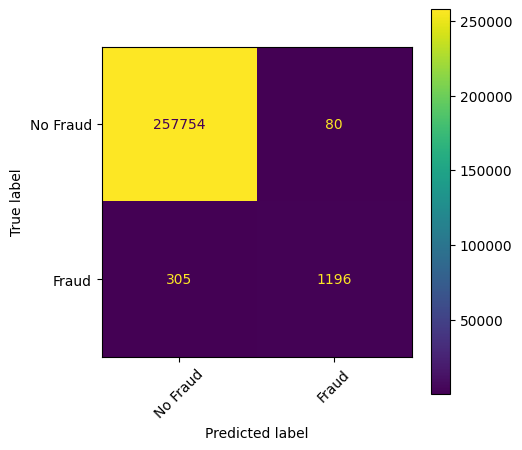

In [ ]:
# confusion matric Decision Tree
cm = confusion_matrix(y_true=y_test, y_pred=dt_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['No Fraud', 'Fraud'])
disp.plot(xticks_rotation=45)
fig = disp.ax_.get_figure()
fig.set_figwidth(5)
fig.set_figheight(5)
plt.show()

Model mendeteksi 80 transaksi Non Fraud menjadi Fraud dan 305 transaksi Fraud menjadi Non Fraud

In [ ]:
dt_model = df_model.loc[df_model['Classifier'] == 'DecisionTreeClassifier', ['Classifier','Test ROC AUC','Test Balanced Accuracy','Test Precision','Test Recall', 'Test F1 Score' ]]
dt_model

,Classifier,Test ROC AUC,Test Balanced Accuracy,Test Precision,Test Recall,Test F1 Score
1,DecisionTreeClassifier,0.898246,0.898246,0.937304,0.796802,0.861361


In [ ]:
# Save model Decision Tree
#joblib.dump(grid_search_dt, 'DecisionTreeClassifier.pkl')

['DecisionTreeClassifier.pkl']